In [124]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tikzplotlib

from tqdm.notebook import tqdm
from pathlib import Path
from collections import defaultdict

MAIN_DIR = Path("/cta/users/aosman/mudcod/simulations/report_comm_detection.ipynb").absolute().parent.parent
SIMULATION_DIR = MAIN_DIR / "simulations"
RESULT_DIR = MAIN_DIR / "results"
RESULTS_PATH = RESULT_DIR / "simulation_results"
FIGURE_DIR = RESULT_DIR / "simulation_figures"
sys.path.append(str(MAIN_DIR))
sys.path.append("../")

import mudcod.utils.visualization as VIS  # noqa: E402

from mudcod.utils import sutils  # noqa: E402

sns.set_theme(style="whitegrid")
sutils.safe_create_dir(RESULTS_PATH)
sutils.safe_create_dir(FIGURE_DIR)

objkey = "loglikelihood"


def get_dataframe(result_dict, index_row, columns, multi_index):
    resultsDf = pd.DataFrame(result_dict["val"], index=index_row, columns=columns)

    if not multi_index:
        resultsDf.reset_index(inplace=True)

    return resultsDf


def get_info_from_name(simul_name):
    mkint = lambda x: int(x[2:])  # noqa: E731
    mkfloat = lambda x: float("0." + x[2:])  # noqa: E731

    simul_info = simul_name.split("_")

    if simul_name.startswith(".") or len(simul_info) != 6:
        raise ValueError(f"Unkown simulation name format: {simul_name}.")

    class_dcbm, case_msd, th, rt, ns, rs = (
        simul_info[0],
        simul_info[1],
        simul_info[2],
        simul_info[3],
        simul_info[4],
        simul_info[5],
    )

    ns, th = mkint(ns), mkint(th)
    rs, rt = mkfloat(rs), mkfloat(rt)

    return class_dcbm, case_msd, th, rt, ns, rs

def read_comm_results(results_path, multi_index=False, class_dcbm_=None, case_msd_=None, th_=None, rt_=None, ns_=None, rs_=None):
    results_path = Path(results_path)
    result_dirs = [f for f in results_path.iterdir() if f.is_dir()]
    result_dict = defaultdict(list)
    num_result = len(result_dirs)

    for i, path in tqdm(enumerate(sorted(result_dirs))):
        pass_iter = False
        simul_name = str(path.stem)
        class_dcbm, case_msd, th, rt, ns, rs = get_info_from_name(simul_name)

        if class_dcbm_ is not None and class_dcbm != class_dcbm_:
            pass_iter = True
        if case_msd_ is not None and case_msd != case_msd_:
            pass_iter = True
        if th_ is not None and th != th_:
            pass_iter = True
        if rt_ is not None and rt != rt_:
            pass_iter = True
        if ns_ is not None and ns != ns_:
            pass_iter = True
        if rs_ is not None and rs != rs_:
            pass_iter = True
        
        if not pass_iter:
            percent = round(100 * i / num_result, 2)
            # print(f"Procesing:%{percent}", class_dcbm, case_msd, th, rt, ns, rs, end="\r")
            # print(simul_name, end="\r")
            # print(path, end="\r")

            communities_path = path / "community_detection"
            muspces_comm_path = communities_path.glob("muspces*.csv")
            for i, mpath in enumerate(sorted(muspces_comm_path)):
                temp = np.genfromtxt(mpath, delimiter=",").flatten()
                # for num_item, val in enumerate(temp):
                #     result_dict["row"].append(
                #          (i, num_item, class_dcbm, case_msd, th, rt, ns, rs, "muspces")
                #     )
                #     result_dict["val"].append(val)
                result_dict["row"].append(
                     (i, class_dcbm, case_msd, th, rt, ns, rs, "muspces")
                     )
                result_dict["val"].append(np.mean(temp))

            pisces_comm_path = communities_path.glob("pisces*.csv")
            for i, ppath in enumerate(sorted(pisces_comm_path)):
                temp = np.genfromtxt(ppath, delimiter=",").flatten()
                # for num_item, val in enumerate(temp):
                #     result_dict["row"].append(
                #      (i, num_item, class_dcbm, case_msd, th, rt, ns, rs, "pisces")
                #      )
                #     result_dict["val"].append(val)
                result_dict["row"].append(
                     (i, class_dcbm, case_msd, th, rt, ns, rs, "pisces")
                     )
                result_dict["val"].append(np.mean(temp))

            static_comm_path = communities_path.glob("static*.csv")
            for i, spath in enumerate(sorted(static_comm_path)):
                temp = np.genfromtxt(spath, delimiter=",").flatten()
                # for num_item, val in enumerate(temp):
                #     result_dict["row"].append(
                #         (i, num_item, class_dcbm, case_msd, th, rt, ns, rs, "static")
                #         )
                #     result_dict["val"].append(val)
                result_dict["row"].append(
                     (i, class_dcbm, case_msd, th, rt, ns, rs, "static")
                     )
                result_dict["val"].append(np.mean(temp))


    index_row = pd.MultiIndex.from_tuples(
        result_dict["row"],
        names=[
            "id",
            # "num_item",
            "class-dcbm",
            "case-msd",
            "time-horizon",
            "r_time",
            "num-subjects",
            "r_subject",
            "method",
        ],
    )
    return get_dataframe(result_dict, index_row, ["mean(ARI)"], multi_index)


def plot_community_detection_results(results_df, figure_path):
    unique_col_val = {}
    for col in results_df.columns:
        unique_col_val[col] = (results_df[col].unique())
    x = "time-horizon"
    y = "mean(ARI)"
    hue = "method"
    col = "r_time"
    row = "r_subject"

    output_path = figure_path / "community_detection"
    sutils.safe_create_dir(output_path)
    fig_list = []
    for class_dcbm in unique_col_val["class-dcbm"]:
        for case_msd in unique_col_val["case-msd"]:
            for ns in unique_col_val["num-subjects"]:
                mask_trip = (
                    (results_df["class-dcbm"] == class_dcbm)
                    & (results_df["case-msd"] == case_msd)
                    & (results_df["num-subjects"] == ns)
                )
                data = results_df[mask_trip]
                title = f"dcbm-class: {class_dcbm} "
                title += f"case-msd: {case_msd} "
                title += f"num-subjects: {str(ns)}"
                g = VIS.point_catplot(
                    data=data, x=x, y=y, hue=hue, col=col, row=row, title=title, figsize=(5,5),
                )
                # g.fig.savefig(
                #     output_path / f"{class_dcbm}_{case_msd}_ns{ns}.png",
                #     bbox_inches="tight",
                # )
                fig_list.append(g)
    return fig_list

In [125]:
RESULTS_PATH

PosixPath('/cta/users/aosman/mudcod/results/simulation_results')

In [116]:
results_df = read_comm_results(RESULTS_PATH, multi_index=False, ns_=8,  class_dcbm_="medium500")

0it [00:00, ?it/s]

In [117]:
results_df[results_df["case-msd"]=="case1"]["id"].max()

99

In [97]:
results_df[results_df["id"]>250][results_df["r_time"]==0][results_df["r_subject"]==0][results_df["case-msd"]=="case3"][results_df["time-horizon"]==8]

/cta/users/aosman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,class-dcbm,case-msd,time-horizon,r_time,num-subjects,r_subject,method,mean(ARI)


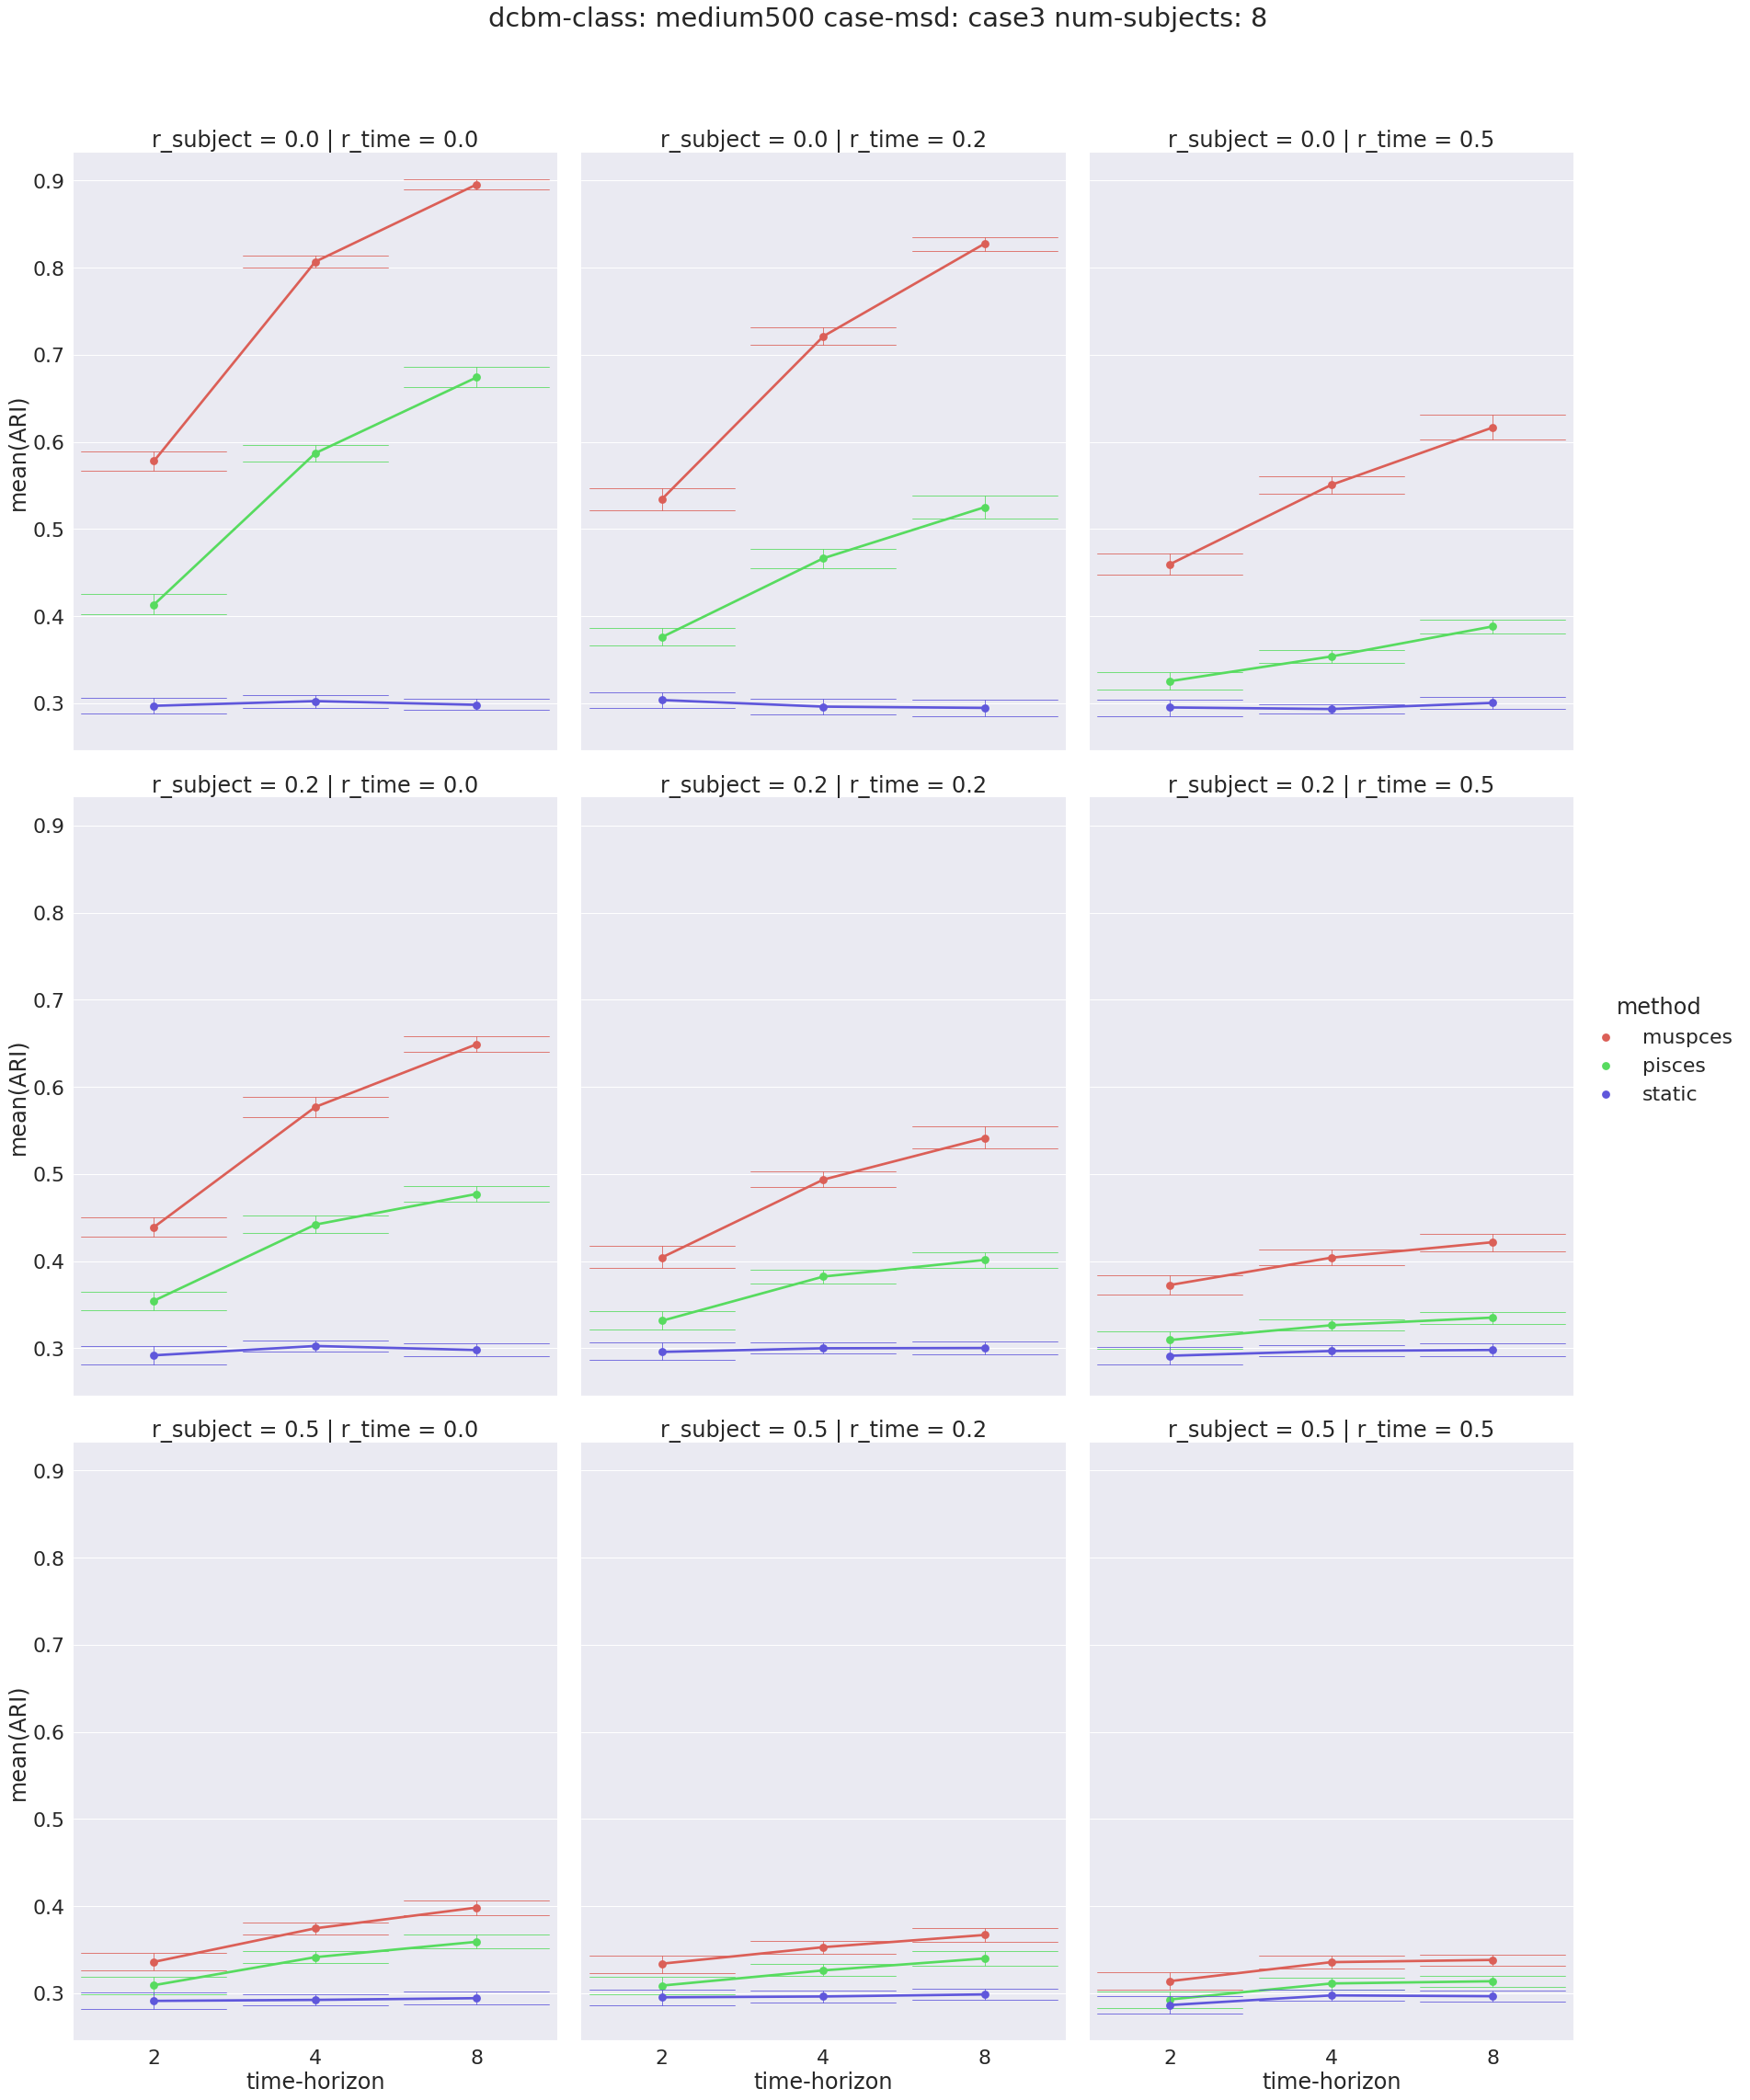

In [128]:
fig_list = plot_community_detection_results(results_df[results_df["case-msd"]=="case3"], FIGURE_DIR)

In [129]:
print(tikzplotlib.get_tikz_code(figure=fig_list[0].fig, textsize=5))

% This file was created by tikzplotlib v0.9.8.
\begin{tikzpicture}

\definecolor{color0}{rgb}{0.917647058823529,0.917647058823529,0.949019607843137}
\definecolor{color1}{rgb}{0.86,0.3712,0.34}
\definecolor{color2}{rgb}{0.34,0.86,0.3712}
\definecolor{color3}{rgb}{0.3712,0.34,0.86}

\begin{groupplot}[group style={group size=3 by 3}]
\nextgroupplot[
axis background/.style={fill=color0},
axis line style={white},
scaled x ticks=manual:{}{\pgfmathparse{#1}},
tick align=outside,
title={r\_subject = 0.0 | r\_time = 0.0},
x grid style={white},
xmajorticks=false,
xmin=-0.5, xmax=2.5,
xtick style={color=white!15!black},
xticklabels={},
y grid style={white},
ylabel={mean(ARI)},
ymajorgrids,
ymajorticks=false,
ymin=0.245712759574139, ymax=0.932391152247258,
ytick style={color=white!15!black},
ytick={0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1},
yticklabels={0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0}
]
\addplot [draw=color1, fill=color1, mark=*, only marks, scatter]
table{%
x  y
0 0.577988753608334
1 0.806853709423

In [103]:
results_df = results_df_medium100[(results_df_medium100["case-msd"] == "case3") & (results_df_medium100["id"] <600)]
unique_col_val = {}
for col in results_df.columns:
    unique_col_val[col] = sorted(results_df[col].unique())

In [106]:
results_dict = {"static":{}, "muspces":{}, "pisces":{}}

for rt in unique_col_val["r_time"]:
    for rs in unique_col_val["r_subject"]:
        for th in unique_col_val["time-horizon"]:
            for method in unique_col_val["method"]:
                mask_trip = (
                        (results_df["time-horizon"] == th)
                        & (results_df["r_time"] == rt)
                        & (results_df["r_subject"] == rs)
                        & (results_df["method"] == method)
                    )
                data = results_df[mask_trip]["mean(ARI)"]
                mean = data.mean()
                print(rt,rs,th,method,mean)
                results_dict[method][rs] = mean
                # lower_bound = results_df[mask_trip]["mean(ARI)"].quantile(0.25)
                # upper_bound = results_df[mask_trip]["mean(ARI)"].quantile(1)
                # mean = data[(data > lower_bound) & (data < upper_bound)].mean()
                # print(rt,rs,th,method,mean)

0.0 0.0 2 muspces 0.7218546883539493
0.0 0.0 2 pisces 0.6817842038261643
0.0 0.0 2 static 0.5396323006546243
0.0 0.0 4 muspces 0.714987883073093
0.0 0.0 4 pisces 0.7009486291891768
0.0 0.0 4 static 0.5388046710366745
0.0 0.0 8 muspces 0.8659620957918288
0.0 0.0 8 pisces 0.8066647365730285
0.0 0.0 8 static 0.538727852918536
0.0 0.2 2 muspces 0.668439735089535
0.0 0.2 2 pisces 0.5542399176420216
0.0 0.2 2 static 0.5352983245704173
0.0 0.2 4 muspces 0.6826729703968727
0.0 0.2 4 pisces 0.5895573737272286
0.0 0.2 4 static 0.5384607648291314
0.0 0.2 8 muspces 0.6913895128934986
0.0 0.2 8 pisces 0.6440599889165958
0.0 0.2 8 static 0.5367174801065999
0.0 0.5 2 muspces 0.5607468097071657
0.0 0.5 2 pisces 0.555599749094545
0.0 0.5 2 static 0.5400110137078213
0.0 0.5 4 muspces 0.5806153566132012
0.0 0.5 4 pisces 0.5810646040577985
0.0 0.5 4 static 0.539664650821729
0.0 0.5 8 muspces 0.5953979204177305
0.0 0.5 8 pisces 0.5541298599547576
0.0 0.5 8 static 0.5388694056641694
0.2 0.0 2 muspces 0.6458

In [112]:
results_dict["muspces"][0.2] - results_dict["pisces"][0.2]

0.07522764120293679